## Data Exploration

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [74]:
import os
from collections import Counter
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
import pylab as pl

In [4]:
data_dir = "../../data"
raw_data_dir = os.path.join(data_dir, "raw")
assert os.path.exists(raw_data_dir)
derived_data_dir = os.path.join(data_dir, "derived")
assert os.path.exists(derived_data_dir)

In [5]:
!ls {raw_data_dir}

item_categories.csv  README.md	      sample_submission.csv  test.csv
items.csv	     sales_train.csv  shops.csv


### Data Loading

In [12]:
item_categories = pd.read_csv(os.path.join(raw_data_dir, "item_categories.csv"))
item_categories.head(n=2)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1


In [13]:
items = pd.read_csv(os.path.join(raw_data_dir, "items.csv"))
items.head(n=2)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76


In [15]:
shops = pd.read_csv(os.path.join(raw_data_dir, "shops.csv"))
shops.head(n=2)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1


In [16]:
sales_train = pd.read_csv(os.path.join(raw_data_dir, "sales_train.csv"))
sales_train.head(n=2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0


In [17]:
test = pd.read_csv(os.path.join(raw_data_dir, "test.csv"))
test.head(n=2)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320


### Data Exploration

In [64]:
Counter(sales_train.date_block_num).most_common()[:10]

[(11, 143246),
 (23, 130786),
 (2, 121347),
 (0, 115690),
 (1, 108613),
 (7, 104772),
 (6, 100548),
 (5, 100403),
 (12, 99349),
 (10, 96736)]

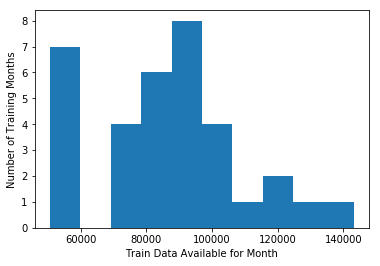

In [47]:
date_data_counts = [count for _, count in Counter(sales_train.date_block_num).most_common()]
plt.hist(date_data_counts)
plt.xlabel("Train Data Available for Month")
plt.ylabel("Number of Training Months")
plt.show()

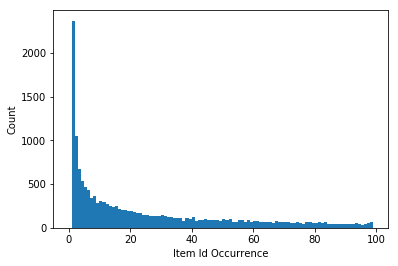

In [28]:
item_id_counts = [count for _, count in Counter(sales_train.item_id).most_common()]
plt.hist(item_id_counts, bins=range(0,100))
plt.xlabel("Item Id Occurrence")
plt.ylabel("Count")
plt.show()

In [32]:
# how many item ids don't appear in the test data?
total_train_items = len(set(sales_train.item_id))
total_test_items_in_train = len(set(sales_train.item_id) & set(test.item_id))
total_test_items = len(set(test.item_id))
print("Total percentage of train item_ids that also appear in the test data:", total_test_items_in_train / total_train_items)
total_train_items, total_test_items, total_test_items_in_train

Total percentage of train item_ids that also appear in the test data: 0.21722382721144587


(21807, 5100, 4737)

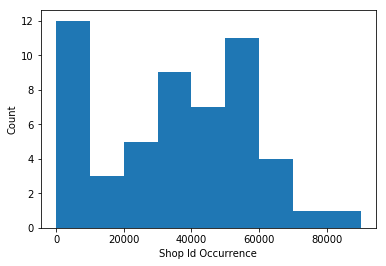

In [34]:
shop_id_counts = [count for _, count in Counter(sales_train.shop_id).most_common()]
plt.hist(shop_id_counts, bins=range(0, 100000, 10000))
plt.xlabel("Shop Id Occurrence")
plt.ylabel("Count")
plt.show()

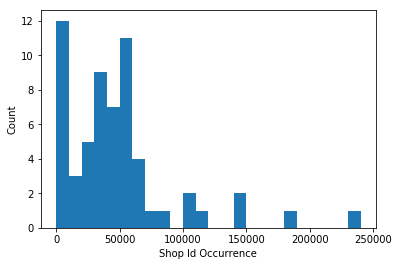

In [38]:
plt.hist(shop_id_counts, bins=range(0, 250000, 10000))
plt.xlabel("Shop Id Occurrence")
plt.ylabel("Count")
plt.show()

In [36]:
# how many shop ids don't appear in the test data?
total_train_shops = len(set(sales_train.shop_id))
total_test_shops_in_train = len(set(sales_train.shop_id) & set(test.shop_id))
total_test_shops = len(set(test.shop_id))
print("Total percentage of train shop_ids that also appear in the test data:", total_test_shops_in_train / total_train_shops)
total_train_shops, total_test_shops, total_test_shops_in_train

Total percentage of train shop_ids that also appear in the test data: 0.7


(60, 42, 42)

In [111]:
merged = sales_train.merge(items, on="item_id", how="left").drop(columns="item_name")
assert len(merged) == len(sales_train)
sales_train = merged

# also merge in the categories to the test data
test = test.merge(items, on="item_id", how="left").drop(columns="item_name")

In [49]:
sales_train.head(n=1)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.0,1.0,37


In [51]:
len(set(sales_train.item_category_id))

84

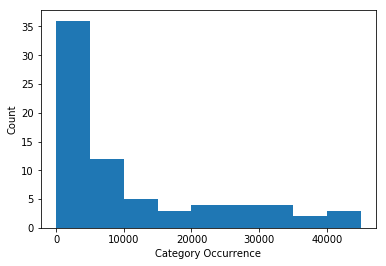

In [55]:
shop_id_counts = [count for _, count in Counter(sales_train.item_category_id).most_common()]
plt.hist(shop_id_counts, bins=range(0, 50000, 5000))
plt.xlabel("Total Category Occurrence")
plt.ylabel("Count")
plt.show()

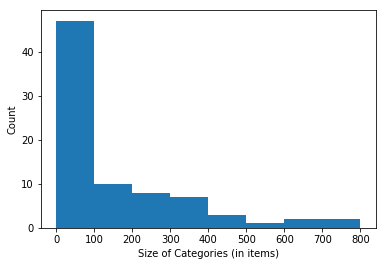

[4964, 2327, 1777, 1100, 769]
Percent of total items contained in the five largest categories: 0.5015362039712019


In [63]:
cat_item_counts = []
for category in set(sales_train.item_category_id):
    items_in_cat = len(set(sales_train[sales_train.item_category_id == category].item_id))
    cat_item_counts.append(items_in_cat)
assert sum(cat_item_counts) == total_train_items
plt.hist(cat_item_counts, bins=range(0, 900, 100))
plt.xlabel("Size of Categories (in items)")
plt.ylabel("Count")
plt.show()
# The majority of categories contain fewer than 100 items
cat_item_counts = sorted(cat_item_counts, reverse=True)
print(cat_item_counts[:5])
print("Percent of total items contained in the five largest categories:", sum(cat_item_counts[:5]) / total_train_items)

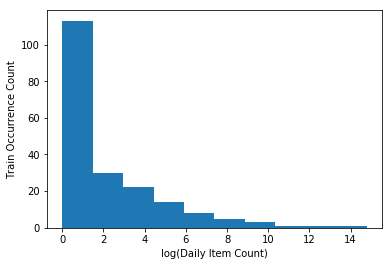

In [76]:
item_cnd_day_counts = [np.log(count) for _, count in Counter(sales_train.item_cnt_day).most_common()]
plt.hist(item_cnd_day_counts)
plt.xlabel("log(Daily Item Count)")
plt.ylabel("Train Occurrence Count")
plt.show()

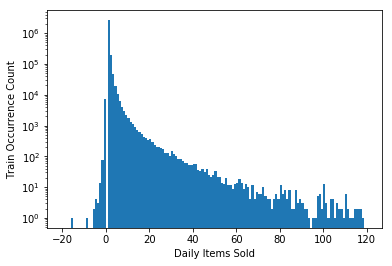

In [110]:
plt.hist([day for day in sales_train.item_cnt_day if day < 150], bins=range(-20,121), log=True)
plt.xlabel("Daily Items Sold")
plt.ylabel("Train Occurrence Count")
plt.show()
# Distribution of item_cnt_day

In [84]:
Counter(sales_train.item_cnt_day).most_common()[:5], min(sales_train.item_cnt_day), max(sales_train.item_cnt_day)

([(1.0, 2629372), (2.0, 194201), (3.0, 47350), (4.0, 19685), (5.0, 10474)],
 -22.0,
 2169.0)

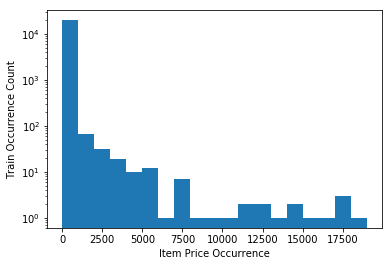

In [107]:
item_price_counts = [count for _, count in Counter(sales_train.item_price).most_common()]
plt.hist(item_price_counts, log=True, bins=range(0,20000,1000))
plt.xlabel("Item Price Occurrence")
plt.ylabel("Train Occurrence Count")
plt.show()

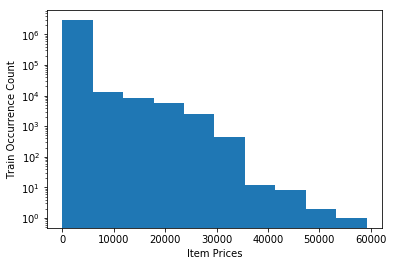

In [100]:
plt.hist([price for price in sales_train.item_price if price < 100000], log=True)
plt.xlabel("Item Prices")
plt.ylabel("Train Occurrence Count")
plt.show()
# Distribution of item_price

In [113]:
sales_train.date.iloc[0]

'02.01.2013'

In [171]:
dates = pd.to_datetime(sales_train.date, format="%d.%m.%Y")
dates[:10]

0   2013-01-02
1   2013-01-03
2   2013-01-05
3   2013-01-06
4   2013-01-15
5   2013-01-10
6   2013-01-02
7   2013-01-04
8   2013-01-11
9   2013-01-03
Name: date, dtype: datetime64[ns]

In [180]:
years = dates.year

AttributeError: 'Series' object has no attribute 'year'

### Weather Data

Weather data from: http://sdwebx.worldbank.org/climateportal/index.cfm?page=downscaled_data_download&menu=historical

In [119]:
weather = pd.read_csv(os.path.join(raw_data_dir, "tas_1991_2015.csv"))
weather.head(n=2)

,tas,Year,Month,Country,ISO3,ISO2
0,-24.424,1991,1,RUS,NaN,NaN
1,-24.688,1991,2,RUS,NaN,NaN


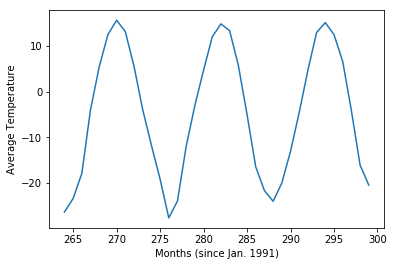

In [166]:
xs = []
ys = []
for i in range(len(weather)):
    if weather.iloc[i].Year < 2013:
        continue
    x = i
    y = weather.iloc[i].tas
    xs.append(x)
    ys.append(y)
    
plt.plot(xs, ys)
locs, labels = plt.xticks()
new_labels = []
for label in labels:
    new_labels.append(label._text)
#new_labels = [str(label) for label in labels]
#plt.xticks(locs, new_labels)
plt.xlabel("Months (since Jan. 1991)")
plt.ylabel("Average Temperature")
plt.show()